# Import libraries

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [ ]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Read metadata

In [ ]:
np.arrange

In [434]:
phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))
el_pos = np.arange(len(phys_pos))[phys_pos-1]
el_pos+1

array([154, 152, 150, 148, 146, 144, 142, 140, 138, 136, 134, 132, 130,
       128, 126, 124, 122, 120, 118, 116, 114, 112, 110, 108, 106, 104,
       102, 100,  98,  96,  94,  92,  90,  88,  86,  84,  82,  80,  78,
        76,  74,  72,  70,  68,  66,  64,  62,  60,  58,  56,  54,  52,
        50,  48,  46,  44,  42,  40,  38,  36,  34,  32,  30,  28,  26,
        24,  22,  20,  18,  16,  14,  12,  10,   8,   6,   4,   2,   1,
         3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,  27,
        29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,  53,
        55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,
        81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131,
       133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153])

In [450]:
np.argsort(phys_pos)+1

array([ 78,  77,  79,  76,  80,  75,  81,  74,  82,  73,  83,  72,  84,
        71,  85,  70,  86,  69,  87,  68,  88,  67,  89,  66,  90,  65,
        91,  64,  92,  63,  93,  62,  94,  61,  95,  60,  96,  59,  97,
        58,  98,  57,  99,  56, 100,  55, 101,  54, 102,  53, 103,  52,
       104,  51, 105,  50, 106,  49, 107,  48, 108,  47, 109,  46, 110,
        45, 111,  44, 112,  43, 113,  42, 114,  41, 115,  40, 116,  39,
       117,  38, 118,  37, 119,  36, 120,  35, 121,  34, 122,  33, 123,
        32, 124,  31, 125,  30, 126,  29, 127,  28, 128,  27, 129,  26,
       130,  25, 131,  24, 132,  23, 133,  22, 134,  21, 135,  20, 136,
        19, 137,  18, 138,  17, 139,  16, 140,  15, 141,  14, 142,  13,
       143,  12, 144,  11, 145,  10, 146,   9, 147,   8, 148,   7, 149,
         6, 150,   5, 151,   4, 152,   3, 153,   2, 154,   1])

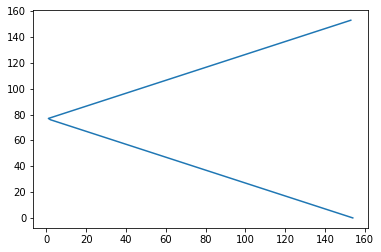

In [442]:
plt.plot(phys_pos, np.arange(len(phys_pos)))

In [448]:
rb_magnet_metadata[rb_magnet_metadata.Circuit=='RB.A12'][['phys_pos','#Electric_circuit']]

,phys_pos,#Electric_circuit
0,1,78
1,2,77
2,3,79
3,4,76
4,5,80
5,6,75
6,7,81
7,8,74
8,9,82
9,10,73


In [405]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata.columns.values

array(['Circuit', 'Magnet', 'Position', 'B1_aperture', 'Diode_type',
       'Correctors', 'EE place', '#Electric_EE', '#Electric_circuit',
       'Cryostat', 'Cryostat2', 'QPS Crate&Board', 'Bus Bar Segment Name',
       '1st Magnet', '2nd Magnet', 'Num of splices', 'Dcum1', 'Dcum2',
       'QPS Crate', 'QPS Board', '#Segment', 'phys_pos', 'Name', 'R_1',
       'R_2', 'RRR_1', 'RRR_2'], dtype=object)

# Select events to analyze

In [5]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

822 3981


In [6]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

563

# Analyze all events

In [95]:
fpa_identifier = "RB_RB.A78_1636740012620000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]

In [293]:
def get_similarity_df(df):
    combinations = []
    for c in df.columns: 
        for j in df.columns:
            if j!=c and not (j + '-' + c in combinations):
                combinations.append(c + '-' + j)

    similarity = np.array([df[c.split('-')[0]].values - df[c.split('-')[1]].values for c in combinations])
    df_similarity = pd.DataFrame(similarity.T, columns=combinations, index=df.index)
    return df_similarity

In [311]:
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values / 1e3

# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=mp3_fpa_df_subset["Circuit Name"].values[0])

# save magnet order for later usage
magnet_list = df_sim.columns

# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in window -1, -10
mean_range = [-1.5, -10]
df_data_noq = df_data_noq.drop(
    df_data_noq.columns[~(mean_range[0] > df_data_noq.mean()) | (mean_range[1] > df_data_noq.mean())],
    axis=1)

# align with energy extraction timestamp
ee_margins = [-0.25, 0.25]
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000,
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
df_data_aligned = align_u_diode_data(df_data=df_data_noq.copy(),
                                     t_first_extraction=t_first_extraction,
                                     ee_margins=ee_margins)

# filter data with 20ms mean filter of sunglasses
t_filter = 0.02 #20ms mean filter
samples_filter =  t_filter / (df_data_aligned.index.values[1] - df_data_aligned.index.values[0])
df_data_filtered = df_data_aligned.rolling(int(samples_filter)).mean()


t_sunglass_activation_magnet = df_data_filtered[df_data_filtered < -1.55].apply(lambda x: x.first_valid_index(), axis=0)

# cut out time frame to analyze
time_frame = [t_sunglass_activation_magnet.min(), t_sunglass_activation_magnet.min()+1.3]
df_data_cut = get_df_time_window(df=df_data_filtered,
                                 timestamp=0,
                                 time_frame=time_frame)#,
                                 #n_samples=n_samples)

# adjust simulation length to data
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)
df_sim_noq_resampled = df_sim_noq_resampled.rolling(int(samples_filter)).mean()

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]

#calculate different crates
crates = rb_magnet_metadata[rb_magnet_metadata['Circuit'] == mp3_fpa_df_subset["Circuit Name"].values[0]]['QPS Crate'].unique()
crate_magents = [rb_magnet_metadata[rb_magnet_metadata['QPS Crate'] == c]['Magnet'].values +':U_DIODE_RB' for c in crates]
# TODO: ref_magnets is only a placeholder for now
next_crate = np.roll(crates,1)
ref_magnets =  [rb_magnet_metadata[rb_magnet_metadata['QPS Crate'] == c]['Magnet'].values[0] +':U_DIODE_RB' for c in next_crate] 
crate_magents_ref = [np.append(crate_magents[i], ref_magnets[i]) for i, c in enumerate(crate_magents)]
df_data_crate_similarity = pd.concat([get_similarity_df(df_data_cut[c]) for c in crate_magents_ref], axis=1)
df_sim_crate_similarity = pd.concat([get_similarity_df(df_sim_noq_resampled[c]) for c in crate_magents_ref], axis=1)

In [314]:
df_data_cut.plot(legend=False) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [315]:
df_data_crate_similarity.plot(legend=False) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [316]:
df_sim_crate_similarity.plot(legend=False) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

In [ ]:
df_sim_noq_resampled.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

# Get all events

In [317]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
warnings.filterwarnings('ignore')

In [318]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [330]:
ds = RBFPAPrimQuenchEEPlateau(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['el_position_feature','event_feature'])

In [320]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

In [ ]:
i = 0
max_deviation = np.zeros(len(mp3_fpa_df_in_dataset))
for k, row in mp3_fpa_df_in_dataset.iterrows():

    d = dataset['data'].loc[{'event': row['fpa_identifier']}]#, 'time':slice(t_ee1 + window[0],t_ee1+ window[1])}]
    d = pd.DataFrame(d.values.T, index=d.time.values).rolling(20).mean()
  
    max_deviation[i] = max(abs(d.min().min() - d.mean().mean()), abs(d.max().max() - d.mean().mean()))
    
    if max_deviation[i] > 1.5:
        plt.figure()
        plt.title(f"{row['Timestamp_PIC']}\ndV: {max_deviation[i]:.2f}V")
        plt.tight_layout()
        plt.xlabel('Time / s')
        plt.ylabel('Voltage / V')
        print(row['fpa_identifier'])
        plt.plot(d.index.values, d.values)
        
    i+=1

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(np.sort(max_deviation)[::-1])
plt.title('Deviation from mean after first EE')
plt.xlabel("Number of events")
plt.ylabel("Voltage / V")
plt.ylim((0,2))
plt.grid()

# fft

In [334]:
dataset_scaled = dataset.copy(deep=True)
dataset_scaled = ds.train_valid_test_split(dataset=dataset_scaled)
dataset_scaled = ds.scale_dataset(dataset=dataset_scaled)

In [505]:
from scipy import signal
from scipy.fft import fft, fftfreq, rfft
from matplotlib import colors

def complex_to_polar(x):
    amplitude = np.abs(x)
    phase = np.arctan2(np.imag(x), np.real(x))  # *180/np.pi
    return amplitude, phase

def get_fft_amplitude(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        x = x * np.hanning(len(x))
        #x = pd.DataFrame(x).rolling(21).mean().values.reshape(-1)
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_phase(DC_Down_data):
    N = len(DC_Down_data)
    x = fft(DC_Down_data)
    return np.arctan2(np.imag(x), np.real(x))[0:N // 2]

def plot_circuit_frequencies_phys_pos(ax, x_fft, frequency):
        
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))
    el_pos = np.argsort(phys_pos)+1
    
    im = ax.imshow(x_fft[el_pos-1], extent=[frequency.min(),frequency.max(),1,154], vmin=0.001, vmax=1, aspect='auto', norm=colors.LogNorm())

    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('Phy. Position')
    ax.set_yticks(np.arange(len(phys_pos))[::9])
    plt.title('Frequency Domain')

    cbar = fig.colorbar(im, pad=0.1)
    cbar.set_label('Scaled Voltage')

    ax2 = ax.twinx()
    ax2.set_ylabel('El. Position')
    ax2.set_yticks(np.arange(len(el_pos))[::9])
    ax2.set_yticklabels(el_pos[::9])

    plt.tight_layout()
    return ax

def plot_circuit_frequencies_center_phys_pos(ax, x_fft, frequency, center_position):
    
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))
    el_pos = np.argsort(phys_pos)+1
    
    index = np.roll(el_pos-1, np.abs(78-center_position))
    
    im = ax.imshow(x_fft[index], extent=[frequency.min(),frequency.max(),1,154], vmin=0.001, vmax=1, aspect='auto', norm=colors.LogNorm())

    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('Phy. Position')
    ax.set_yticks(np.arange(len(index))[::9])
    ax.set_yticklabels(index[::9])
    plt.title('Frequency Domain')

    cbar = fig.colorbar(im, pad=0.1)
    cbar.set_label('Scaled Voltage')

    plt.tight_layout()
    return ax


def plot_circuit_frequencies(ax, x_fft, frequency):
    im = ax.imshow(x_fft, extent=[frequency.min(),frequency.max(),1,154], vmin=0.001, vmax=1, aspect='auto', norm=colors.LogNorm())
    
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('El. Position')
    ax.set_yticks(np.arange(1,155)[::9])
    plt.title('Frequency Domain')

    cbar = fig.colorbar(im, pad=0.1)
    cbar.set_label('Scaled Voltage')

    ax2 = ax.twinx()
    ax2.set_ylabel('Phys. Position')
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))[::9]
    ax2.set_yticks(np.arange(len(phys_pos)))
    ax2.set_yticklabels(phys_pos)

    plt.tight_layout()
    return ax


def plot_circuit_frequencies_center(ax, x_fft, frequency, center_position):
    
    index = np.roll(np.arange(154), np.abs(78-center_position))
    
    im = ax.imshow(x_fft[index], extent=[frequency.min(),frequency.max(),1,154], vmin=0.001, vmax=1, aspect='auto', norm=colors.LogNorm())
    
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('El. Position')
    ax.set_yticks(np.arange(len(index))[::9])
    ax.set_yticklabels(index[::9])
    plt.title('Frequency Domain')

    cbar = fig.colorbar(im, pad=0.1)
    cbar.set_label('Scaled Voltage')

    ax2 = ax.twinx()
    ax2.set_ylabel('Phys. Position')
    phys_pos = np.hstack((abs(np.arange(-154,0,2)),np.arange(1,155,2)))[index][::9]
    ax2.set_yticks(np.arange(len(phys_pos)))
    ax2.set_yticklabels(phys_pos)

    plt.tight_layout()
    return ax

In [499]:
mp3_fpa_df_in_dataset[mp3_fpa_df_in_dataset.fpa_identifier==dataset_scaled[{'event': 0}].event.values]['phys_position'].iloc[0]

152.0

In [497]:
dataset_scaled[{'event': 0}].event.values

array('RB_RB.A12_1543810849860000000', dtype='<U29')

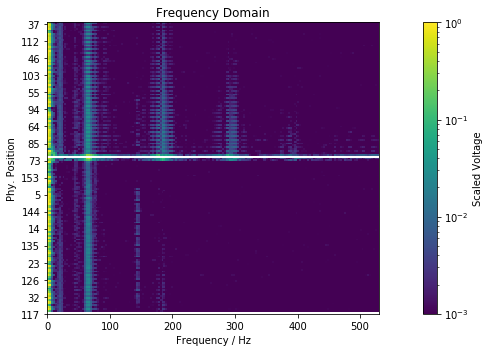

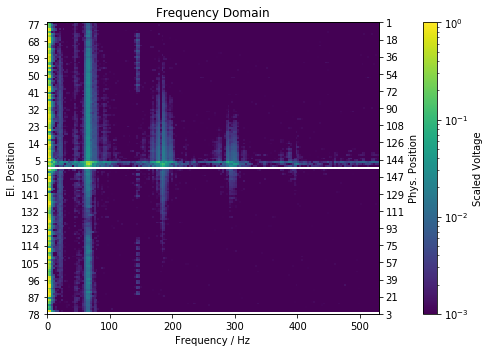

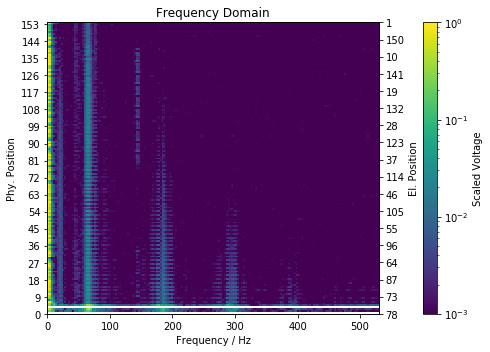

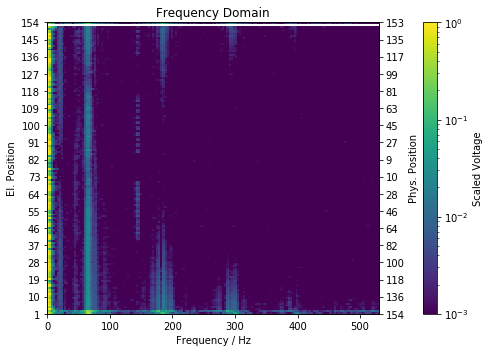

In [508]:
x_time = dataset_scaled[{'event': 0}].data.values
x_fft = np.array([get_fft_amplitude(x) for x in x_time])
dt= dataset[{'event': 0}].time[1].values -dataset[{'event': 0}].time[0].values
frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2] 

fig, ax = plt.subplots(figsize=(7,5))
plot_circuit_frequencies_center_phys_pos(ax, x_fft, frequency, center_position=152)

fig, ax = plt.subplots(figsize=(7,5))
plot_circuit_frequencies_center(ax, x_fft, frequency, center_position=2)

fig, ax = plt.subplots(figsize=(7,5))
plot_circuit_frequencies_phys_pos(ax, x_fft, frequency)

fig, ax = plt.subplots(figsize=(7,5))
plot_circuit_frequencies(ax, x_fft, frequency)

In [326]:
%matplotlib inline
#widget

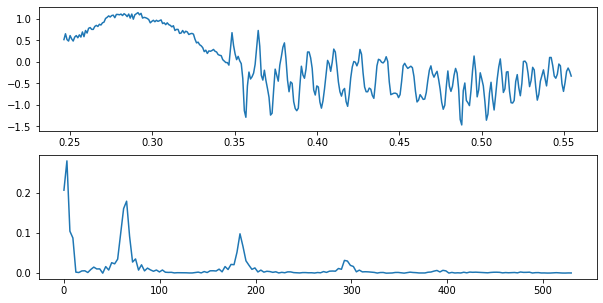

<Figure size 432x288 with 0 Axes>

In [393]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(dataset[{'event': 0}].time.values, x_time[0])
ax[1].plot(frequency, x_fft[0])
plt.show()
plt.tight_layout()

In [363]:
dataset_fft = xr.apply_ufunc(get_fft_amplitude, 
                             dataset_scaled.data,
                             input_core_dims=[['time']], 
                             output_core_dims=[['frequency']], 
                             exclude_dims=set(("time",)),
                             vectorize=True)



# 2D-tSNE

# look for concepts

In [396]:
use_fft = 'max'
if use_fft == 'stack':
    X_input_tsne = np.nan_to_num(np.log(dataset_fft.values.reshape(len(dataset_fft.event),-1)))
elif use_fft == 'max':
    X_input_tsne = np.nan_to_num(np.log(dataset_fft.mean(dim=['el_position']).values))
else:
    X_input_tsne = np.nan_to_num(dataset_scaled.data.values.reshape(len(dataset_scaled.event),-1))
    
X_embedded = TSNE(n_components=2).fit_transform(X_input_tsne.astype(np.float32))

In [397]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_
k_examples = 3
center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0:k_examples])

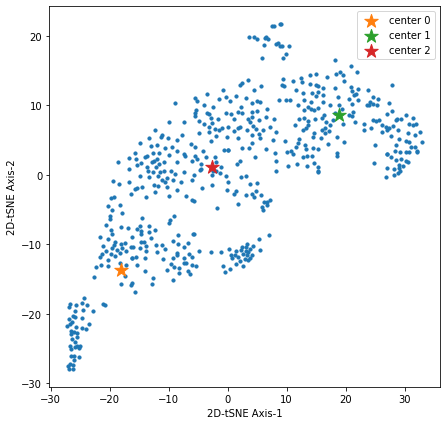

In [398]:
plt.figure(figsize=(7,7))
#plt.grid()

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=10)
for i, center in enumerate(centers):
    plt.scatter(x=center[0], y=center[1], label=f"center {i}", s=200, marker='*')
    
plt.xlabel('2D-tSNE Axis-1')
plt.ylabel('2D-tSNE Axis-2')
plt.legend()
plt.show()

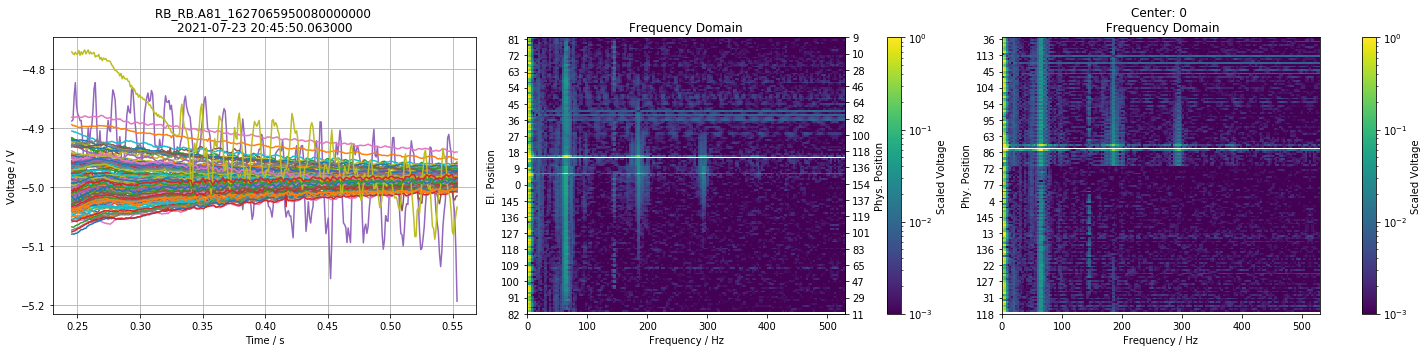

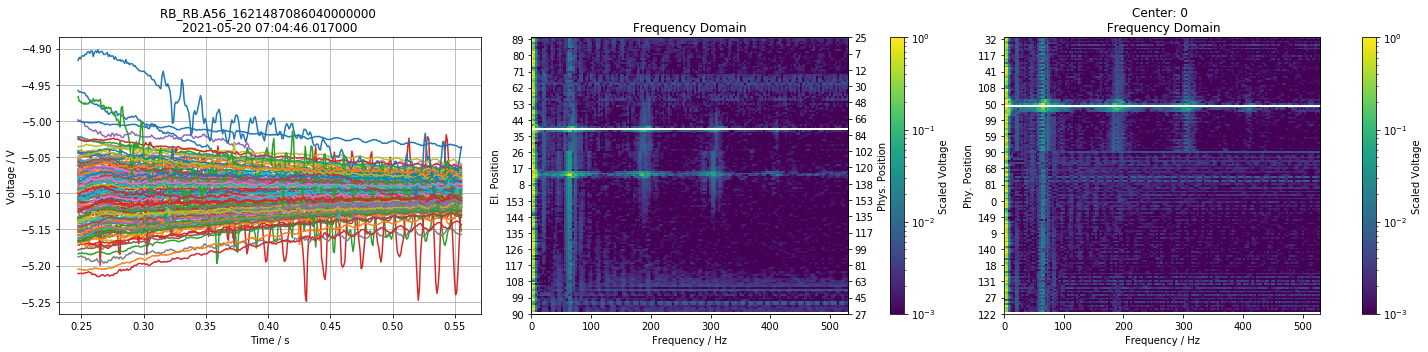

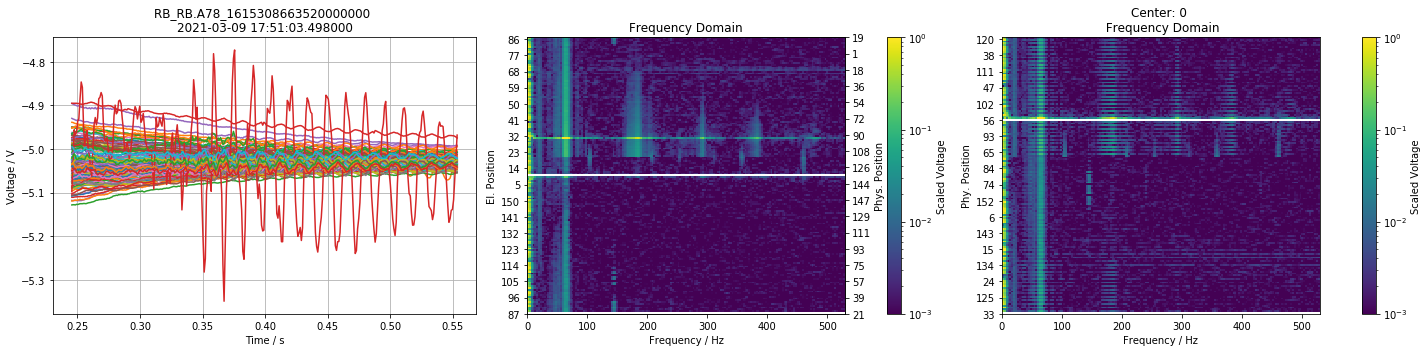

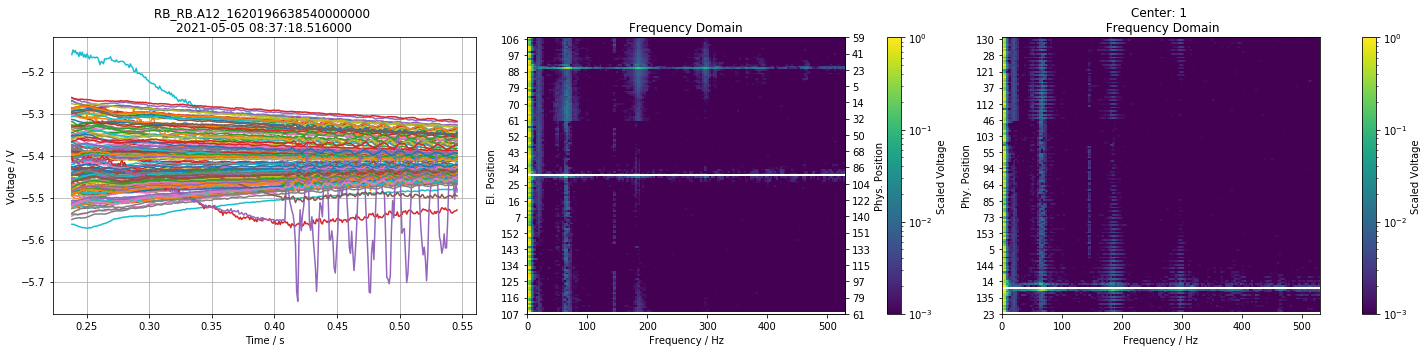

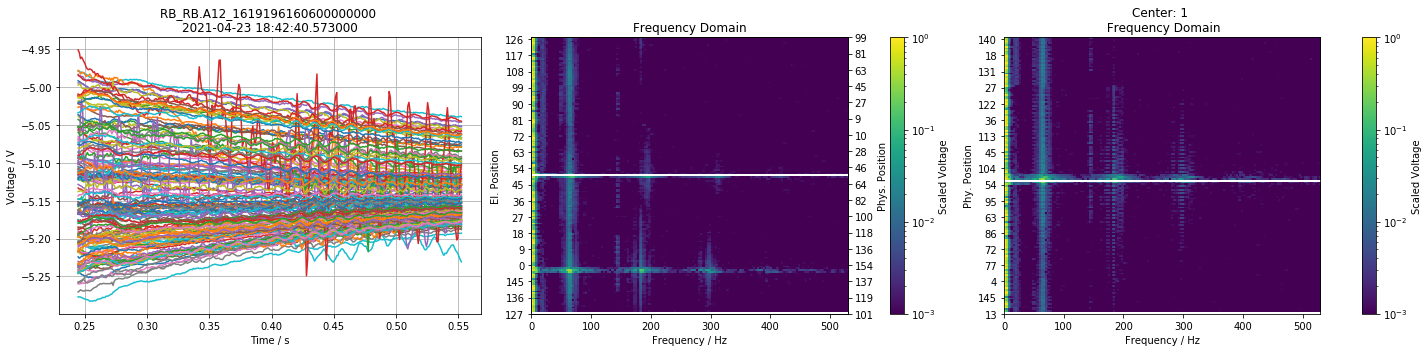

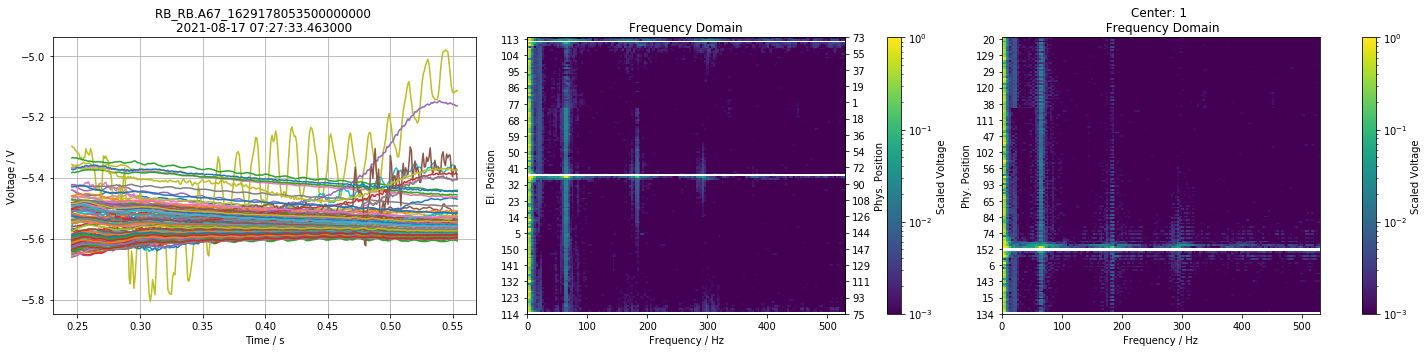

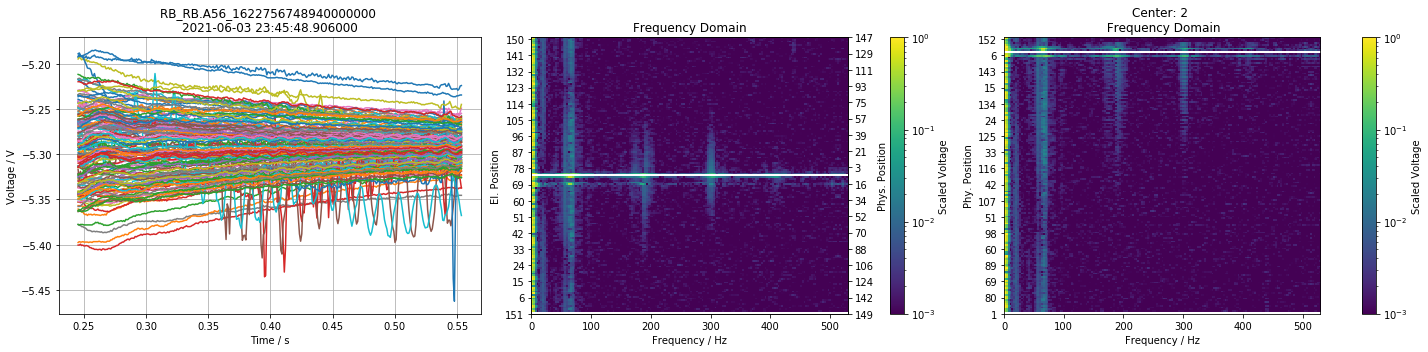

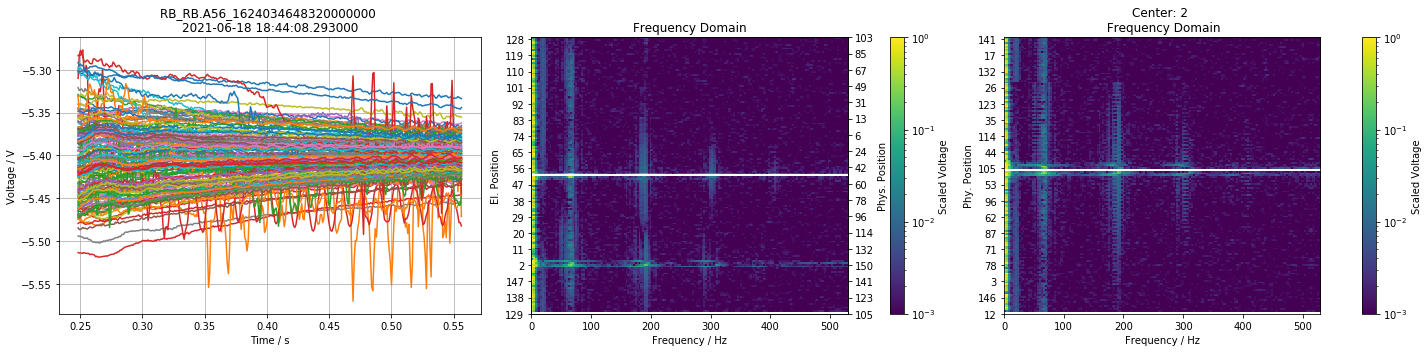

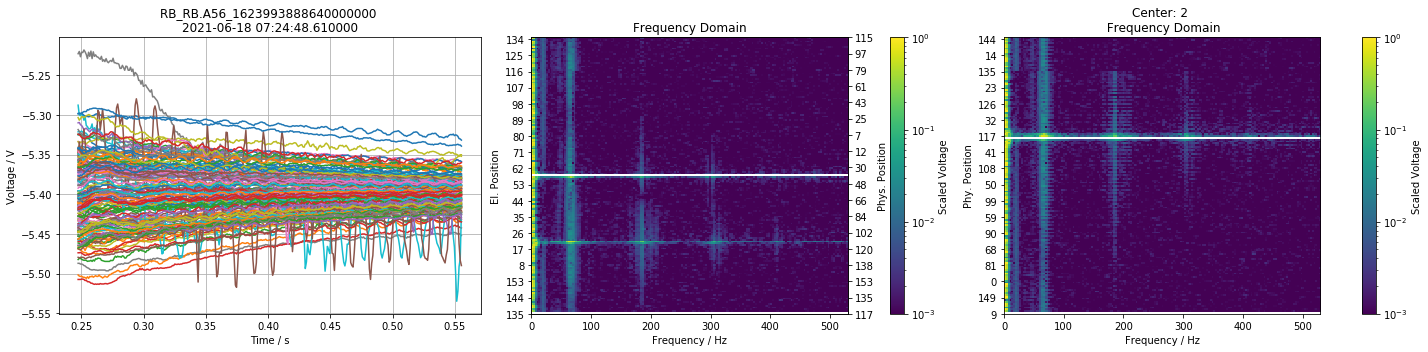

In [511]:
for i, examples in enumerate(center_indices):
    for example in examples:
        fig, ax = plt.subplots(1,3, figsize=(20,5))
        ax[0].plot(dataset[{'event': example}].time, dataset[{'event': example}].data.T)
        fpa_identifier =  dataset[{'event': example}].event.values
        date = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['Timestamp_PIC'].values[0]
        ax[0].grid()

        current = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['I_end_2_from_data'].values[0]
        ax[0].set_title(f"{fpa_identifier} \n{date}")
        ax[0].set_xlabel('Time / s')
        ax[0].set_ylabel('Voltage / V')
        

        quench_position = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['#Electric_circuit'].values[0]
        
        x_fft = dataset_fft[{'event': example}].data
        frequency = fftfreq(len(x_time[0]), dt)[:len(x_time[0])//2]  
        ax[1] = plot_circuit_frequencies_center(ax[1], x_fft, frequency, int(quench_position))
        #ax[1].set_title(f'Center: {i} \n Frequency Domain')
        
        #ax[1].plot(frequency, np.log(np.nan_to_num(x_fft).max(axis=0)))
        #ax[1].set_title(f'Maximal Frequency Amplitude')
        #ax[1].set_ylim((0,10))
        quench_position_phys = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['phys_position'].values[0]
        ax[2] = plot_circuit_frequencies_center_phys_pos(ax[2], x_fft, frequency, int(quench_position))
        ax[2].set_title(f'Center: {i} \n Frequency Domain')